# Twitter-Swisscom Project

## EVENT DETECTION 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from utils import *
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import euclidean_distances
from scipy.cluster.hierarchy import ward, dendrogram,fcluster

from sklearn.cluster import DBSCAN
from sklearn import metrics

import datashader as ds
import datashader.transfer_functions as tf

In [2]:
col_event_split = ['id','userId', 'createdAt', 'text', 'longitude', 'latitude', 'placeId', 'inReplyTo', 'placeLatitude', 'placeLongitude']

In [3]:
parse_dates = ['createdAt']

In [4]:
tweets = pd.read_csv('../twitter-swisscom/twex_event_corrected.tsv', sep="\t", encoding='utf-8', escapechar='\\', names=col_event_split, parse_dates=parse_dates, na_values='N', header=None, nrows=10000)

In [5]:
tweets.head()

,id,userId,createdAt,text,longitude,latitude,placeId,inReplyTo,placeLatitude,placeLongitude
0,9514097914,17341045,2010-02-23 05:55:51,Guuuuten Morgen! :-),7.43926,46.9489,NaN,NaN,NaN,NaN
1,9514846412,7198282,2010-02-23 06:22:40,Still the best coffee in town — at La Stanza h...,8.53781,47.3678,NaN,NaN,NaN,NaN
2,9516574359,14657884,2010-02-23 07:34:25,It has been a week or so.. and today I just co...,6.13396,46.1951,NaN,NaN,NaN,NaN
3,9516952605,14703863,2010-02-23 07:51:47,Getting ready.. http://twitpic.com/14v8gz,8.81749,47.2288,NaN,NaN,NaN,NaN
4,9517198943,14393717,2010-02-23 08:02:57,Un peu de réconfort liquide en take away après...,6.63254,46.5199,NaN,NaN,NaN,NaN


In [6]:
tweets.drop(['placeId', 'inReplyTo'], inplace=True, axis=1)

Different informations on the longitude and latitude are given, the columns longitude/latitude are the position of the Tweet as reported by the user or client application. The place longitude/latitude is  indicates that the tweet is associated (but not necessarily originating from) a Place. And as we can see on the head of the table, the place is not always set.

We decided to use the longitude/latitude columns to represent the position of a tweet and if they are null we will use the placeLatitude and placeLongitude. If both are null we will have to drop the entry as a tweet without position is not usefull for event detection.

In [7]:
tweets.dtypes

id                         int64
userId                     int64
createdAt         datetime64[ns]
text                      object
longitude                float64
latitude                 float64
placeLatitude            float64
placeLongitude           float64
dtype: object

In [8]:
tweets = tweets.apply(replace_position, axis=1)

In [9]:
tweets.head()

,id,userId,createdAt,text,longitude,latitude,placeLatitude,placeLongitude
0,9514097914,17341045,2010-02-23 05:55:51,Guuuuten Morgen! :-),7.43926,46.9489,NaN,NaN
1,9514846412,7198282,2010-02-23 06:22:40,Still the best coffee in town — at La Stanza h...,8.53781,47.3678,NaN,NaN
2,9516574359,14657884,2010-02-23 07:34:25,It has been a week or so.. and today I just co...,6.13396,46.1951,NaN,NaN
3,9516952605,14703863,2010-02-23 07:51:47,Getting ready.. http://twitpic.com/14v8gz,8.81749,47.2288,NaN,NaN
4,9517198943,14393717,2010-02-23 08:02:57,Un peu de réconfort liquide en take away après...,6.63254,46.5199,NaN,NaN


We can now drop the columns placeLongitude and placeLatitude as they don't give us anymore informations.

In [10]:
tweets.drop(['placeLatitude', 'placeLongitude'],inplace=True, axis=1)

Then we drop the NaN values in Longitude and Latitude columns as we need a position to detect event.

In [11]:
len_before = len(tweets.index)
tweets = tweets.dropna(subset=['longitude', 'latitude'])
len_after = len(tweets.index)
print("Number of tweets before dropping the one without position : ", len_before)
print("Number of tweets before dropping the one without position : ", len_after)
print("Percentage of tweets lost : ", ((len_before - len_after)/len_before)*100)

Number of tweets before dropping the one without position :  10000
Number of tweets before dropping the one without position :  10000
Percentage of tweets lost :  0.0


As we also base our event detection on the text field we don't want to have nan value in it. So we drop them.

In [12]:
len_before = len(tweets.index)
tweets = tweets.dropna(subset=['text'])
len_after = len(tweets.index)
print("Number of tweets before dropping the one without text : ", len_before)
print("Number of tweets before dropping the one without text : ", len_after)
print("Percentage of tweets lost : ", ((len_before - len_after)/len_before)*100)

Number of tweets before dropping the one without text :  10000
Number of tweets before dropping the one without text :  10000
Percentage of tweets lost :  0.0


We want to detect the event from the tweets we now extracted. To do so we had to do some assumptions. We decided to work with the text to find event. 
- Hashtags can be a good estimators of what event were on at the time of the tweets.
- Events can take place on several days but we will decide to take tweets day per day.

As we decided to detect an event by its day of occurence we create a new column that gives us the information of the day.

In [13]:
tweets['day'] = pd.DatetimeIndex(tweets['createdAt']).normalize()

We decide to remove the stopwords from the tweets' text to keep only words that can describe an event.

In [14]:
stop_words = stopwords.words('english')
stop_words += stopwords.words('french')
stop_words += stopwords.words('german')
stop_words += stopwords.words('italian')
stop_words += string.punctuation
stop_words += ['—','/via','i\'m', '^_^', ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
':c', ':{', '>:\\', ';(', ':-)', ':)', ';)','[=o)]', ';-)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
'=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
'<3']

In [15]:
def text_process(row):
    text = row['text']
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@ \S+", "", text)
    text = re.sub(r"@\S+", "", text)
    text = text.split()
    text  = [word for word in text if word.lower() not in stop_words]
    row['text'] = text
    return row

We remove the stopwords but we also remove the URLs and the @ mentions as they are not useful to detect events

In [16]:
tweets = tweets.apply(text_process, axis=1)
tweets.head()

,id,userId,createdAt,text,longitude,latitude,day
0,9514097914,17341045,2010-02-23 05:55:51,"[Guuuuten, Morgen!]",7.43926,46.9489,2010-02-23
1,9514846412,7198282,2010-02-23 06:22:40,"[Still, best, coffee, town, Stanza]",8.53781,47.3678,2010-02-23
2,9516574359,14657884,2010-02-23 07:34:25,"[week, so.., today, couldn't, focus, Sportif, ...",6.13396,46.1951,2010-02-23
3,9516952605,14703863,2010-02-23 07:51:47,"[Getting, ready..]",8.81749,47.2288,2010-02-23
4,9517198943,14393717,2010-02-23 08:02:57,"[peu, réconfort, liquide, take, away, après, d...",6.63254,46.5199,2010-02-23


Now that the text is pretty much clean we want to get the hashtags from the tweets because they are really helpful to detect the events. So we create a column with the hashtags :

In [17]:
tweets['hashtags'] = tweets['text'].apply(find_hashtags)

And in the "text" fields we don't want to have '#' anymore.

In [18]:
tweets['text'] = tweets['text'].apply(remove_hashtags)

We want to detect event that took place in switzerland so the longitude/latitude should be on the Switzerland land. (Done externally using OSGeo4W)
We save our current work to run it on our external pipeline (see directory country-detection)

In [19]:
tweets.to_csv("../twitter-swisscom/twex_event_before_country.csv", sep=',', encoding='utf-8', index=False)

Now that we added the country to it, we open the new csv

In [20]:
tweets = pd.read_csv("../twitter-swisscom/twex_event_country.csv", sep=',', encoding='utf-8')

In [21]:
tweets.head()

,id,userId,createdAt,text,longitude,latitude,day,hashtags,country
0,9514097914,17341045,2010-02-23 05:55:51,"['Guuuuten', 'Morgen!']",7.43926,46.9489,2010-02-23 00:00:00,[],CH
1,9514846412,7198282,2010-02-23 06:22:40,"['Still', 'best', 'coffee', 'town', 'Stanza']",8.53781,47.3678,2010-02-23 00:00:00,[],CH
2,9516574359,14657884,2010-02-23 07:34:25,"['week', 'so..', 'today', ""couldn't"", 'focus',...",6.13396,46.1951,2010-02-23 00:00:00,[],CH
3,9516952605,14703863,2010-02-23 07:51:47,"['Getting', 'ready..']",8.81749,47.2288,2010-02-23 00:00:00,[],CH
4,9517198943,14393717,2010-02-23 08:02:57,"['peu', 'réconfort', 'liquide', 'take', 'away'...",6.63254,46.5199,2010-02-23 00:00:00,[],CH


We only keep the tweets that are in Switzerland

In [22]:
len_total = len(tweets)
tweets = tweets[tweets.country == 'CH']
len_swiss = len(tweets)
print("Tweets total : ", len_total)
print("Tweets without the tweets out of Switzerland : ", len_swiss)
print("Loss percentage : ", (1-(len_swiss/len_total))*100, "%")

Tweets total :  10000
Tweets without the tweets out of Switzerland :  8732
Loss percentage :  12.680000000000003 %


In [23]:
if 0:
    tweets.to_csv("../twitter-swisscom/final_tweets_for_event_detection.csv", sep=',', encoding='utf-8', index=False)

## EVENT  DETECTION

Now that our dataframe is clean we want to find the event hidden in all those tweets. Here are our assumptions to find an event :
- An event is described by a list of words (hashtags are also used with greater importance than other words)
- An event takes place at a certain place described by longitude/latitude (we took around 10km)
- An event occurs during a certain  time (we decided to find them day by day)
- An event has a minimum number of people talking about it (we took 3) and a minimum of tweets (we took 5)

We want to find where the tweets are sent from to imagine where the clusters will be.

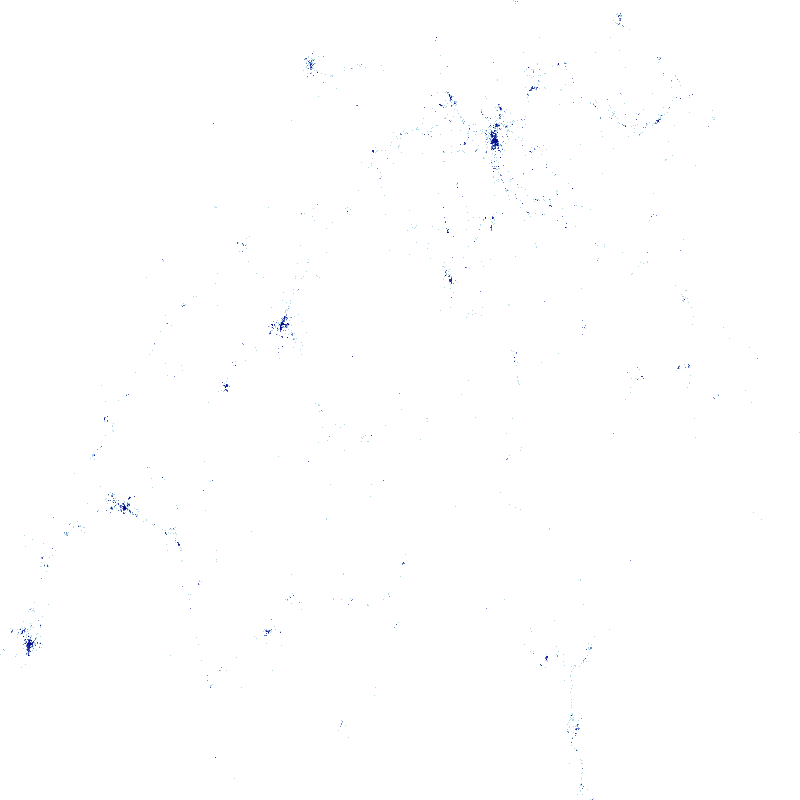

In [24]:
cvs = ds.Canvas(plot_width=800, plot_height=800)
agg = cvs.points(tweets, 'longitude', 'latitude')
tf.shade(agg)

We can easily see the map of Switzerland and most users in Switzerland can be found in Geneva, Lausanne and Zürich. There are other regions with some activity too.

As we want to detect event day per day we will have to go through all the day in our data and for each of them detect the events.

In [25]:
days = np.unique(tweets['day'].values)
print(len(days))

161


#### One day detection

In [26]:
day = tweets[tweets['day']==days[1]]
day.head()

,id,userId,createdAt,text,longitude,latitude,day,hashtags,country
23,9564394826,17910879,2010-02-24 06:09:23,"['Eigentlich', 'möchte', 'heute', 'morgen', 'j...",7.90625,47.3513,2010-02-24 00:00:00,"['insider', 'fb']",CH
24,9564875001,17341045,2010-02-24 06:26:53,"['Good', 'morning!', 'Black', 'Eyed', 'Peas', ...",7.44237,46.8958,2010-02-24 00:00:00,[],CH
25,9566362388,13199732,2010-02-24 07:26:32,"['became', 'mayor', 'Phonak', 'AG']",8.74314,47.2392,2010-02-24 00:00:00,[],CH
26,9566536362,14260616,2010-02-24 07:33:49,"['Hallo', 'Presse,', 'Blick', 'Co.', 'Wann', '...",8.29933,47.4834,2010-02-24 00:00:00,['Blick'],CH
27,9567368800,6589882,2010-02-24 08:10:43,"['train', 'Genève']",6.37155,46.4742,2010-02-24 00:00:00,[],CH


In [27]:
meters = 10000
eps = meters / 100000 # meters to degree

In [28]:
X = day.as_matrix(columns=['latitude', 'longitude'])
db = DBSCAN(eps=eps, min_samples=5).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [29]:
day = day.assign(cluster=db.labels_)

In [30]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)


Estimated number of clusters: 2


C:\Users\Alain\Anaconda3\lib\site-packages\matplotlib\lines.py:1145: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


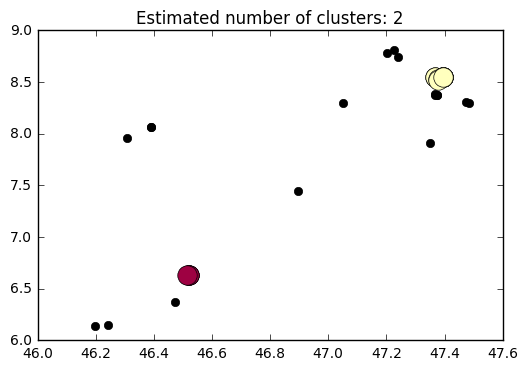

In [31]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

## Text analysis to detect events

We go through the clusters and find out if the corresponding tweets are linked by an event or not. To do so we first of all create a dataframe that will contain the events. (Event name, Event keywords, Event hashtags, Event longitude/latitude, Number of tweets, Number of people)

In [55]:
df_event = pd.DataFrame(columns=['name', 'date', 'keywords', 'hashtags', 'longitude', 'latitude', '# of tweets', '# of people', 'tweetids'])

Now we want to populate our dataframe with real event. So we go through all the clusters and find out the hashtags, keywords and corresponding event based on these two infos

In [56]:
for day in days:
    day_df = tweets[tweets['day']==day]
    
    X = day_df.as_matrix(columns=['latitude', 'longitude'])
    db = DBSCAN(eps=eps, min_samples=5).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    
    day_df = day_df.assign(cluster=db.labels_)
    
    #Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    
    for cluster in range(0,n_clusters_-1):
        ntweets = len(day_df[day_df['cluster']==cluster])
        npeople = len(np.unique(day_df[day_df['cluster']==cluster].userId))
        ids = list(day_df[day_df['cluster']==cluster].id.values)
        #print("Cluster n°" + str(cluster) + "( " + str(ntweets) + " tweets" + " )")
        d_hashtags = dictionnary_from_hashtags(day_df, cluster)
        d_keywords = dictionnary_from_keywords(day_df, cluster)

        d_hashtags_detection = useful_(d_hashtags, 1/3, ntweets)
        d_keywords_detection = useful_(d_keywords, 1/4, ntweets)

        if(not any(d_hashtags_detection)):
            if(any(d_keywords_detection)):
                pass
                # TODO only keywords
        else:
            position = find_position(day_df, cluster, ntweets)
            i = len(df_event)
            name = ""
            for elem in d_hashtags_detection.keys(): 
                name += elem + " "
            df_event.loc[i] = ([name, day, list(d_keywords_detection.keys()), list(d_hashtags_detection.keys()), position[0], position[1], ntweets, npeople, ids])
            print(" ------- Event added -------")

 ------- Event added -------
 ------- Event added -------
 ------- Event added -------
 ------- Event added -------
 ------- Event added -------
 ------- Event added -------
 ------- Event added -------
 ------- Event added -------
 ------- Event added -------
 ------- Event added -------
 ------- Event added -------


In [57]:
len(df_event)

11

We want to avoid having spam event in our event dataframe. It means that the ratio tweet per user should not be too big. Here we decided to set this ratio to 6.

In [58]:
df_event = df_event[df_event["# of tweets"]/df_event["# of people"] < 6]

We also want to have more than 2 people per event and more than 7 tweets.

In [59]:
df_event = df_event[(df_event["# of people"] >= 3) & (df_event["# of tweets"] >= 8)]

In [60]:
len(df_event)

8

In [61]:
df_event

,name,date,keywords,hashtags,longitude,latitude,# of tweets,# of people,tweetids
0,zhwahlen2010,2010-03-07 00:00:00,[zhwahlen2010],[zhwahlen2010],8.530788,47.371580,10.0,3.0,"[10096142854, 10117661003, 10122712301, 101240..."
1,cern lhc,2010-03-30 00:00:00,"[7tev, cern, lhc]","[cern, lhc]",6.117434,46.206506,16.0,6.0,"[11290380524, 11290576184, 11291387514, 112915..."
3,fb,2010-05-22 00:00:00,[fb],[fb],6.141726,46.196613,8.0,4.0,"[14473013419, 14477514037, 14477623268, 144796..."
4,gfsc2010,2010-05-29 00:00:00,[gfsc2010],[gfsc2010],6.148203,46.209564,11.0,4.0,"[14958559754, 14959412920, 14963118521, 149633..."
5,bcbs10,2010-06-05 00:00:00,[bcbs10],[bcbs10],9.170459,47.667207,14.0,3.0,"[15474249596, 15475025339, 15476055767, 154770..."
7,mcw,2010-06-12 00:00:00,[mcw],[mcw],8.534659,47.381571,14.0,6.0,"[15989515737, 15990232708, 15990669914, 159936..."
8,worldcup,2010-06-16 00:00:00,"[Swiss, worldcup]",[worldcup],8.294810,47.080213,8.0,3.0,"[16285080907, 16301206563, 16305938657, 163098..."
9,swisscrmforum,2010-06-24 00:00:00,[swisscrmforum],[swisscrmforum],8.543925,47.402544,43.0,15.0,"[16910610939, 16911022902, 16911067954, 169121..."


In [45]:
df_event['date'] = pd.DatetimeIndex(df_event['date']).normalize()

In [47]:
df_event

,name,date,keywords,hashtags,longitude,latitude,# of tweets,# of people,tweetids
0,zhwahlen2010,2010-03-07,zhwahlen2010,zhwahlen2010,8.530788,47.371580,10.0,3.0,"[10096142854, 10117661003, 10122712301, 101240..."
1,cern lhc,2010-03-30,"7tev, cern, lhc","cern, lhc",6.117434,46.206506,16.0,6.0,"[11290380524, 11290576184, 11291387514, 112915..."
2,fb,2010-05-22,fb,fb,6.141726,46.196613,8.0,4.0,"[14473013419, 14477514037, 14477623268, 144796..."
3,gfsc2010,2010-05-29,gfsc2010,gfsc2010,6.148203,46.209564,11.0,4.0,"[14958559754, 14959412920, 14963118521, 149633..."
4,bcbs10,2010-06-05,bcbs10,bcbs10,9.170459,47.667207,14.0,3.0,"[15474249596, 15475025339, 15476055767, 154770..."
5,mcw,2010-06-12,mcw,mcw,8.534659,47.381571,14.0,6.0,"[15989515737, 15990232708, 15990669914, 159936..."
6,worldcup,2010-06-16,"Swiss, worldcup",worldcup,8.294810,47.080213,8.0,3.0,"[16285080907, 16301206563, 16305938657, 163098..."
7,swisscrmforum,2010-06-24,swisscrmforum,swisscrmforum,8.543925,47.402544,43.0,15.0,"[16910610939, 16911022902, 16911067954, 169121..."


In [48]:
df_event.to_csv("../twitter-swisscom/twex_event_final_events_10000.csv", sep=',', encoding='utf-8', index=False)

In [40]:
df_event = pd.read_csv("../twitter-swisscom/twex_event_final_events_10000.csv", sep=',', encoding='utf-8')

In [41]:
def correct_df(row):
    row['keywords'] = row['keywords'][2:-2]
    newkeywords = ""
    for index in range(0, len(row['keywords'])):
        if row['keywords'][index]!="'":
            newkeywords += row['keywords'][index]
    row['keywords'] = newkeywords
    
    row['hashtags'] = row['hashtags'][2:-2]
    newhashtags = ""
    for index in range(0, len(row['hashtags'])):
        if row['hashtags'][index]!="'":
            newhashtags += row['hashtags'][index]
    row['hashtags'] = newhashtags
    return row

In [42]:
df_event = df_event.apply(correct_df, axis=1)

In [43]:
from ast import literal_eval

for index in range(0,len(df_event)):
    newlist_keywords = literal_eval(df_event.keywords[index])
    df_event.keywords[index] = newlist_keywords
    
    newlist_hashtags = literal_eval(df_event.hashtags[index])
    df_event.hashtags[index] = newlist_hashtags

ValueError: malformed node or string: <_ast.Name object at 0x0000022A0CCFA278>

In [ ]:
df_event

In [ ]:
df_event.to_csv("../twitter-swisscom/event_detected_final.csv", sep=',', encoding='utf-8', index=False)